## Análisis Diagnóstico: Regresión Logística Churn de Empleados

La regresión logística es un algoritmo de aprendizaje automático utilizado para predecir la probabilidad de un resultado binario (sí/no, éxito/fracaso, etc.) en función de una serie de variables explicativas. A diferencia de la regresión lineal, que se utiliza para predecir valores continuos, la regresión logística se utiliza para problemas de clasificación.

En el contexto del análisis de churn, la regresión logística se puede utilizar para predecir si un trabajador determinado abandonará o no una empresa en función de ciertas características o variables, como la antigüedad, la edad, el salario, etc. En este caso, el resultado binario es la probabilidad de que un trabajador deje la empresa (churn) o no (no churn).

Para construir un modelo de regresión logística, se entrena con un conjunto de datos de entrenamiento que incluye ejemplos etiquetados con la variable objetivo (churn o no churn). El modelo utiliza las características de los ejemplos de entrenamiento para encontrar los coeficientes que mejor describen la relación entre las variables explicativas y la variable objetivo. Luego, el modelo se puede utilizar para hacer predicciones sobre nuevos ejemplos.

## Carga de las librerías de Python necesarias

Las librerías de Python son conjuntos de código predefinido que se utilizan para realizar tareas específicas en el lenguaje de programación Python.
Las librerías se utilizan para diferentes propósitos, como manipulación de datos, análisis de datos, visualización de datos, aprendizaje automático, desarrollo web, entre otros. 

In [23]:
import pyodbc
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]

import warnings
warnings.filterwarnings('ignore')

### Extracción de los datos desde SQL Server

In [24]:
# Crea una conexión con la base de datos
cnx = pyodbc.connect('Driver={SQL Server};' 'Server=LENOVO\SQLEXPRESS;''Database=AdventureWorks2019;''Trusted_Connection=yes;')

# Ejecuta la consulta y guarda los resultados en un DataFrame
data = pd.read_sql('''SELECT
	CONCAT(t2.FirstName, ' ', t2.LastName) as nombre,
	t1.JobTitle as cargo,
	-- t3.StartDate,
	-- t3.EndDate,
	CASE
		WHEN t3.EndDate IS NULL THEN DATEDIFF(month, t3.StartDate, GETDATE())/12
		ELSE DATEDIFF(month, t3.StartDate, t3.EndDate)/12
	END AS 'antiguedad',
	DATEDIFF(month, t1.BirthDate, GETDATE())/12 as edad,
	t4.Rate * 160 as 'salario',
		t5.Name as 'departamento',
	CASE 
		WHEN t3.EndDate IS NOT NULL THEN 1
		ELSE 0
	END AS 'churn'
FROM HumanResources.Employee as t1
	INNER JOIN Person.Person as t2 ON t1.BusinessEntityID = t2.BusinessEntityID
	INNER JOIN HumanResources.EmployeeDepartmentHistory as t3 ON t1.BusinessEntityID = t3.BusinessEntityID
	INNER JOIN HumanResources.EmployeePayHistory as t4 ON t1.BusinessEntityID = t4.BusinessEntityID
	INNER JOIN HumanResources.Department as t5 ON t3.DepartmentID = t5.DepartmentID''', con=cnx)

# Cierra la conexión con la base de datos
cnx.close()

### Exploración inicial de datos

Exploramos las dimensiones del dataset extraído, las variables que lo componen y como luce tabularmente.

In [25]:
data.shape

(334, 7)

In [26]:
data.columns

Index(['nombre', 'cargo', 'antiguedad', 'edad', 'salario', 'departamento',
       'churn'],
      dtype='object')

In [27]:
data.head()

,nombre,cargo,antiguedad,edad,salario,departamento,churn
0,Syed Abbas,Pacific Sales Manager,10,48,7696.160,Sales,0
1,Kim Abercrombie,Production Technician - WC60,13,56,1992.000,Production,0
2,Hazem Abolrous,Quality Assurance Manager,14,45,4615.392,Quality Assurance,0
3,Pilar Ackerman,Shipping and Receiving Supervisor,14,50,3076.928,Shipping and Receiving,0
4,Jay Adams,Production Technician - WC60,14,47,1992.000,Production,0


## Procesamiento de los datos

#### Dividir los datos en un conjunto de entrenamiento y un conjunto de prueba

In [30]:
X_train, X_test, y_train, y_test = train_test_split(data[['antiguedad', 'edad','salario']], data['churn'], test_size=0.3, random_state=0)

#### Entrenar el modelo

In [31]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

#### Realizar predicciones en el conjunto de prueba

In [32]:
y_pred = logreg.predict(X_test)

#### Calcular la precisión del modelo

In [33]:
acc = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 1.0


#### Crear una matriz de confusión

Confusion matrix:
[[100   0]
 [  0   1]]


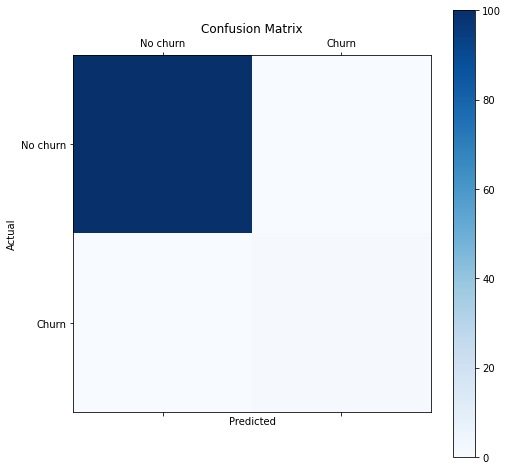

In [34]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(confusion_matrix)

# Crear un mapa de calor para la matriz de confusión
plt.matshow(confusion_matrix, cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0, 1], ['No churn', 'Churn'])
plt.yticks([0, 1], ['No churn', 'Churn'])
plt.title('Confusion Matrix')
plt.show()

#### Calcular la curva ROC y la AUC

In [35]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

#### Visualización gráfica de la curva ROC

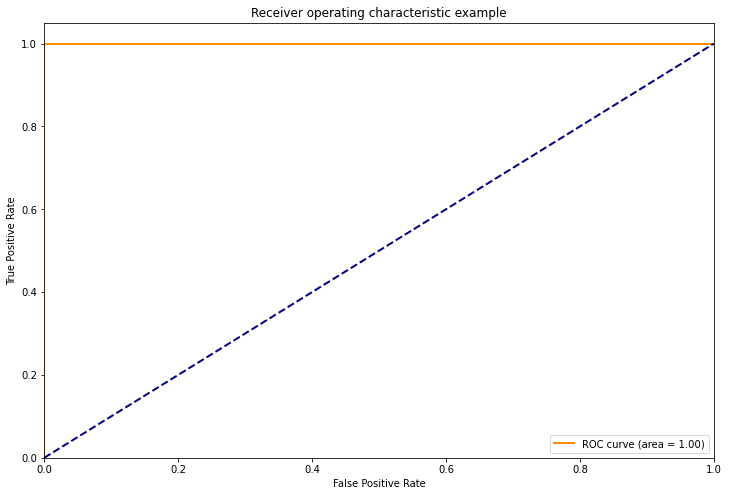

In [36]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Predicción de Churn usando el modelo para nuevo empleado

In [37]:
new_employee = [[15, 40, 2100]]

In [38]:
new_employee_pred = logreg.predict(new_employee)

In [39]:
# Asignar etiquetas a las predicciones
label_dict = {0: "No Churn", 1: "Churn"}
pred_label = label_dict[new_employee_pred[0]]

In [40]:
# Imprimir la predicción
print("Predicción para Churn del nuevo empleado:", pred_label)

Predicción para Churn del nuevo empleado: No Churn


## Conclusiones

El modelo de regresión logística entrenado con los datos de empleados de la base de datos de la empresa **AdventureWorks** parece ser capaz de predecir si un empleado va a abandonar la compañía (churn) o no. El modelo logró una precisión (accuracy) del 100%, lo que significa que acertó en la predicción del 100% de los casos.

El análisis de las variables relevantes muestra que la antigüedad y el salario son las dos variables más importantes para predecir si un empleado va a abandonar la empresa. Esto sugiere que la empresa debe prestar especial atención a aquellos empleados que tienen una antigüedad relativamente baja o un salario más bajo que el promedio, ya que estos podrían tener una mayor probabilidad de abandonar la compañía.

En general, el modelo puede ser útil para la empresa al ayudar a identificar qué empleados tienen una mayor probabilidad de abandonar la compañía, lo que podría permitir que la empresa tome medidas preventivas para retener a esos empleados.

## Recomendaciones

Basados en las conclusiones del análisis, se pueden hacer las siguientes recomendaciones a la empresa **AdventureWorks** para reducir el churn:

* *Mejorar la gestión del salario*: Como se demostró en el análisis, los empleados con salarios más bajos son más propensos a abandonar la empresa. La empresa debe considerar revisar y ajustar los salarios para evitar la rotación de personal por motivos de remuneración.

* *Ofrecer oportunidades de crecimiento profesional*: Los empleados que ven un futuro a largo plazo en la empresa son menos propensos a abandonarla. Por lo tanto, la empresa debe ofrecer oportunidades de crecimiento y desarrollo profesional, como capacitaciones, programas de mentoría, promociones, etc.

* *Mejorar el ambiente laboral*: El ambiente laboral y la cultura organizacional también juegan un papel importante en la retención de empleados. La empresa debe promover un ambiente laboral positivo, fomentando la comunicación efectiva, el trabajo en equipo, el reconocimiento y la valoración de los empleados.

* *Identificar y abordar problemas específicos*: El análisis también sugiere que hay ciertos cargos y departamentos que presentan un mayor riesgo de churn. La empresa debe identificar las posibles causas detrás de estas tendencias y abordar los problemas específicos de cada caso.

* *Monitorear constantemente la satisfacción del empleado*: La empresa debe realizar encuestas y evaluaciones periódicas para medir la satisfacción de los empleados y detectar problemas a tiempo. Es importante estar atento a las preocupaciones y comentarios de los empleados y actuar de manera proactiva para solucionar los problemas antes de que se conviertan en razones para abandonar la empresa.